<a href="https://colab.research.google.com/github/Lindakk/Coronavirus-tweets-NLP-Text-Classification/blob/main/text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#!pip install -U transformers
#!pip install -U acceerate
##!pip install -U datasets
#!pip install -U bertviz
#!pip install -U umap-learn

In [13]:
import pandas as pd
import zipfile
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
with zipfile.ZipFile('/content/Corona_NLP_train.csv.zip','r') as zip:
  zip.extractall('/content')

In [15]:
df_train=pd.read_csv('/content/Corona_NLP_train.csv',encoding='latin1')
df_test=pd.read_csv('/content/Corona_NLP_test.csv', encoding='latin1')

In [16]:
df_train.isnull().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


In [17]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)

In [18]:
df_train = df_train[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
df_test = df_test[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
label_mapping = {
    'Extremely Positive':4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative':0

}
df_train['label']=df_train.sentiment.map(label_mapping)
df_train.head()

,tweets,sentiment,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2
1,advice Talk to your neighbours family to excha...,Positive,3
2,Coronavirus Australia: Woolworths to give elde...,Positive,3
3,My food stock is not the only one which is emp...,Positive,3
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [19]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)


    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


    return wierd_pattern.sub(r'', text)

def remove_punctuation(text):
    # Remove punctuation and carriage return/newline characters
    cleaned_text = re.sub(r'[^\w\s]+|[\r\n]', '', text)
    return cleaned_text

def remove_extra_white_spaces(text):
    clean_text=text.strip()
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=clean_text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_punctuation(remove_emojis(convert_to_lower(text))))

df_train['tweets'] = df_train['tweets'].apply(preprocessText)
df_test['tweets'] = df_test['tweets'].apply(preprocessText)

Text(0.5, 1.0, 'Frequency of Classes')

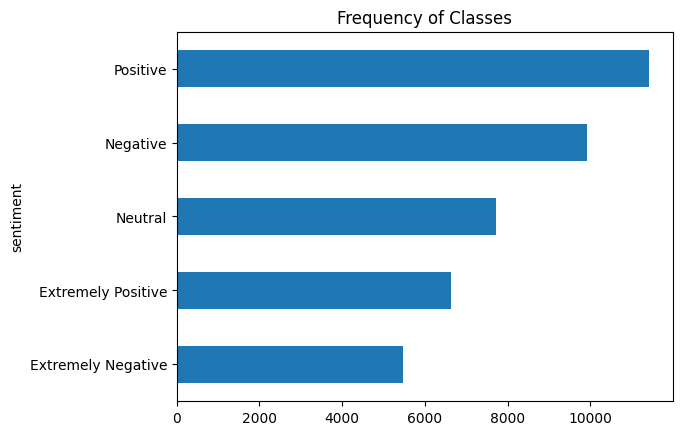

In [20]:
lable_counts=df_train['sentiment'].value_counts(ascending=True)
lable_counts.plot(kind='barh')
plt.title('Frequency of Classes')

In [21]:
df_train['Words per tweet']=df_train['tweets'].str.split().apply(len)

(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'Extremely Negative'),
  Text(2, 0, 'Extremely Positive'),
  Text(3, 0, 'Negative'),
  Text(4, 0, 'Neutral'),
  Text(5, 0, 'Positive')])

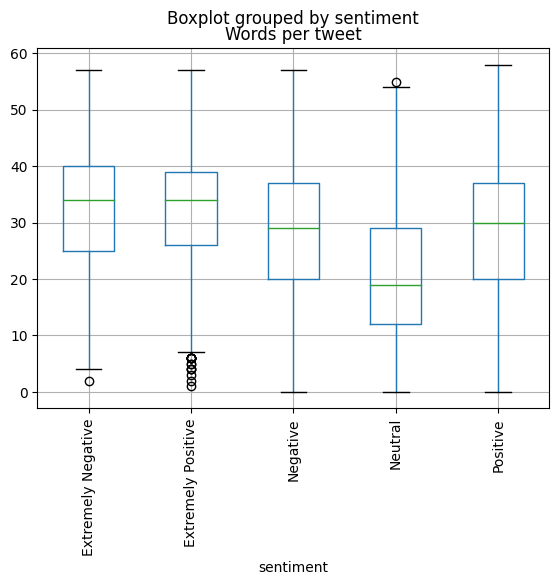

In [22]:
df_train.boxplot('Words per tweet',by='sentiment')
plt.xticks(rotation=90)

In [23]:
from transformers import AutoTokenizer
model_ckpt='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_train,test_size=0.3,stratify=df_train.sentiment)
test, val=train_test_split(test,test_size=1/3,stratify=test.sentiment)

In [25]:
train.shape,test.shape,val.shape

((28809, 4), (8232, 4), (4116, 4))

In [26]:
from datasets import Dataset, DatasetDict
dataset=DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation':Dataset.from_pandas(val,preserve_index=False)
     }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 28809
    })
    test: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 8232
    })
    validation: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 4116
    })
})

In [27]:
dataset['train'][0],dataset['train'][1]

({'tweets': 'alphabets drone delivery company wing has seen surge in demand in recent weeks making over 1000 deliveries in the last two weeks delivery numbers have doubled in the us and australia',
  'sentiment': 'Negative',
  'label': 1,
  'Words per tweet': 31},
 {'tweets': 'it twas the night before easter and coronavirus fears were spreading all through the houseeveryone was quarantined with masks over their mouthspeter was in his bedroom and susie was in the basement while mommy and daddy worked on toiletpaper replacement easter2020',
  'sentiment': 'Negative',
  'label': 1,
  'Words per tweet': 41})

In [28]:
def tokenize(batch):
  temp=tokenizer(batch['tweets'],padding=True,truncation=True,max_length=512)
  return temp
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 12440, 2015, 18465, 6959, 2194, 3358, 2038, 2464, 12058, 1999, 5157, 1999, 3522, 3134, 2437, 2058, 6694, 23534, 1999, 1996, 2197, 2048, 3134, 6959, 3616, 2031, 11515, 1999, 1996, 2149, 1998, 2660, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2009, 1056, 17311, 1996, 2305, 2077, 10957, 1998, 21887, 23350, 10069, 2020, 9359, 2035, 2083, 1996, 2160, 22507, 14001, 2063, 2001, 24209, 20486, 10196, 2094, 2007, 15806, 2058, 2037, 15076, 22327, 2121, 2001, 1999, 2010, 5010, 1998, 23917, 2001, 1999, 1996, 8102, 2096, 20565, 1998, 8600, 2499, 2006, 11848, 23298, 6110, 10957, 11387, 11387, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [29]:
setiment_encoded=dataset.map(tokenize,batched=True, batch_size=None)

Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/8232 [00:00<?, ? examples/s]

Map:   0%|          | 0/4116 [00:00<?, ? examples/s]

In [30]:
label2id={x['sentiment']:x['label'] for x in dataset['train']}
id2label={v:k for k, v in label2id.items()}
label2id, id2label

({'Negative': 1,
  'Positive': 3,
  'Extremely Positive': 4,
  'Neutral': 2,
  'Extremely Negative': 0},
 {1: 'Negative',
  3: 'Positive',
  4: 'Extremely Positive',
  2: 'Neutral',
  0: 'Extremely Negative'})

In [31]:
from transformers import AutoModel


In [32]:
model=AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [33]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [34]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

num_labels=len(label2id)
device=torch.device('cuda' if torch.cuda.is_available() else'cpu')
config=AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Extremely Negative",
    "1": "Negative",
    "2": "Neutral",
    "3": "Positive",
    "4": "Extremely Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Extremely Negative": 0,
    "Extremely Positive": 4,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [39]:
from transformers import TrainingArguments

batch_size=64
training_dir='bert_base_train_dir'
training_args=TrainingArguments(output_dir=training_dir,
                                overwrite_output_dir=True,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                evaluation_strategy='epoch',
                                disable_tqdm=False
                                )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
#pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [41]:
import evaluate

accuracy=evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [43]:
from sklearn.metrics import accuracy_score,f1_score
def compute_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {'accuracy':acc,'f1':f1}

In [47]:
from transformers import Trainer
trainer=Trainer(model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=setiment_encoded['train'],
                eval_dataset=setiment_encoded['validation'],
                tokenizer=tokenizer)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.820033,0.675413,0.667406
2,1.044500,0.615850,0.775267,0.775115
